## Generate the pkl files

Before you start, copy the script in [this script](https://github.com/ramp-kits/supernovae/blob/master/utils/serialize_lsst_sn_sims.py) to your local directory.


Choose a model to validate. In this example, we will work with MODEL01.
Using an environment with Python3, do in the command line

```
>> python serialize_lsst_sn_sims.py <LSST_sim_dir> --timed
```

where <LSST_sim_dir> is the directory where the FITS files for the model you will analyze are located.

In my case that was

```
>> python serialize_lsst_sn_sim.py ../../data/PLASTICC_2018-02-10/LSST_DDF_MODEL01/ --timed
```

This will create in your local directory a file named `LSST_DDF_MODEL01_train.pkl` which will be used from now on as the data source.

## Read the data

The functions bellow will convert the pkl file into pandas data frames

In [15]:
import gzip
import pickle
import pandas as pd
import numpy as np

LSST_FILTERS = 'ugrizY'


def read_data(filename):
    """Read data from pickled file to a pandas dataframe"""
    with gzip.open(filename, 'rb') as f:
        data = pickle.load(f)

    X = to_dataframe(data)
    y = pd.get_dummies(X.type == 0, prefix='SNIa', drop_first=True)
    X = X.drop(columns=['type'])

    return X, y


def to_dataframe(data):
    """Converts from a python dictionary to a pandas dataframe"""
    for idx in data:
        sn = data[idx]
        for filt in LSST_FILTERS:
            sn['mjd_%s' % filt] = np.array(sn[filt]['mjd'])
            sn['fluxcal_%s' % filt] = np.array(sn[filt]['fluxcal'])
            sn['fluxcalerr_%s' % filt] = np.array(sn[filt]['fluxcalerr'])
            del sn[filt]
        sn.update(sn['header'])
        del sn['header']

    return pd.DataFrame.from_dict(data, orient='index')

Now you can use the data doing

In [16]:
X, y = read_data('LSST_DDF_MODEL01_train.pkl')

The `X` contain the data itself. You can take a look at what IDs are present in X by using

In [17]:
X.index[:100]

Int64Index([   1,   11,   37,   50,  121,  133,  137,  154,  156,  164,  186,
             187,  204,  280,  345,  349,  352,  360,  371,  376,  401,  404,
             412,  417,  457,  540,  541,  611,  618,  674,  704,  720,  737,
             741,  744,  745,  749,  766,  794,  831,  858,  862,  880,  901,
             906,  933,  938,  977, 1011, 1071, 1215, 1231, 1256, 1257, 1304,
            1309, 1334, 1336, 1339, 1346, 1353, 1413, 1447, 1514, 1520, 1585,
            1607, 1610, 1613, 1618, 1639, 1653, 1746, 1758, 1769, 1810, 1813,
            1893, 1918, 1922, 1946, 2053, 2067, 2124, 2136, 2162, 2169, 2170,
            2178, 2179, 2180, 2208, 2236, 2271, 2291, 2296, 2305, 2313, 2332,
            2350],
           dtype='int64')

In [18]:
# Get one supernovae - the first in the list
X.iloc[0]

mjd_u                                                          []
fluxcal_u                                                      []
fluxcalerr_u                                                   []
mjd_g                                                          []
fluxcal_g                                                      []
fluxcalerr_g                                                   []
mjd_r           [59801.355, 59826.312, 59842.246, 59854.148, 5...
fluxcal_r       [-0.0254864, 0.575477, 1.01247, -1.35183, -0.6...
fluxcalerr_r    [1.6725, 0.852579, 0.789432, 1.13981, 1.70968,...
mjd_i           [59798.336, 59801.371, 59826.324, 59842.262, 5...
fluxcal_i       [2.35333, -0.858802, 2.043, -1.16096, 3.08165,...
fluxcalerr_i    [1.90091, 2.32897, 1.55345, 1.35922, 2.00832, ...
mjd_z           [59798.348, 59801.383, 59826.336, 59842.273, 5...
fluxcal_z       [1.68631, 5.13968, -0.0989522, -1.70304, -1.74...
fluxcalerr_z    [2.47812, 3.05156, 2.07812, 2.08502, 2.79906, ...
mjd_Y     

You can choose one specific SN through its ID. For example, if you wish to access the SN 1618,

In [19]:
X.loc[1618]

mjd_u                                                          []
fluxcal_u                                                      []
fluxcalerr_u                                                   []
mjd_g                                                          []
fluxcal_g                                                      []
fluxcalerr_g                                                   []
mjd_r           [59801.355, 59826.312, 59842.246, 59854.148, 5...
fluxcal_r       [-0.448459, -2.15695, -1.12113, -0.649874, -0....
fluxcalerr_r    [1.67251, 0.852238, 0.788678, 1.1398, 1.70968,...
mjd_i           [59798.336, 59801.371, 59826.324, 59842.262, 5...
fluxcal_i       [-0.60553, -2.89826, -1.10115, 0.737174, 3.627...
fluxcalerr_i    [1.89995, 2.329, 1.55245, 1.35962, 2.00855, 2....
mjd_z           [59798.348, 59801.383, 59826.336, 59842.273, 5...
fluxcal_z       [-1.45936, 3.3925, 3.01045, -0.690947, 0.35663...
fluxcalerr_z    [2.47759, 3.05107, 2.07928, 2.08501, 2.79914, ...
mjd_Y     

The y holds the IDs in crescent order

In [20]:
y[:10]

""
1
11
37
50
121
133
137
154
156
164


## Plotting the Light curves

You can use the utility bellow to plot one (or a few) light curves

In [21]:
#Plot the data
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

LSST_FILTERS = 'ugrizY'

def plot_lightcurves(idx, X):    
    
    flux = []
    for f in LSST_FILTERS:
        if len(X.iloc[idx]['fluxcal_' + f]) > 0:
            flux.append(max(X.iloc[idx]['fluxcal_' + f]))
            
    for id_f, f in enumerate(LSST_FILTERS):
        
        
        ax = axes[id_f // 3, id_f % 3]
        ax.errorbar(X.iloc[idx]['mjd_%s' % f] - X.iloc[idx]['pkmjd'], 
                    X.iloc[idx]['fluxcal_%s' % f]/max(flux), 
                    X.iloc[idx]['fluxcalerr_%s' % f]/max(flux), 
                    fmt='o')
        ax.set_xlabel('MJD')
        ax.set_ylabel('Calibrated flux')
        ax.set_title('%s-band' % f)

The functionality bellow will plot light curves in sequence, order by ID

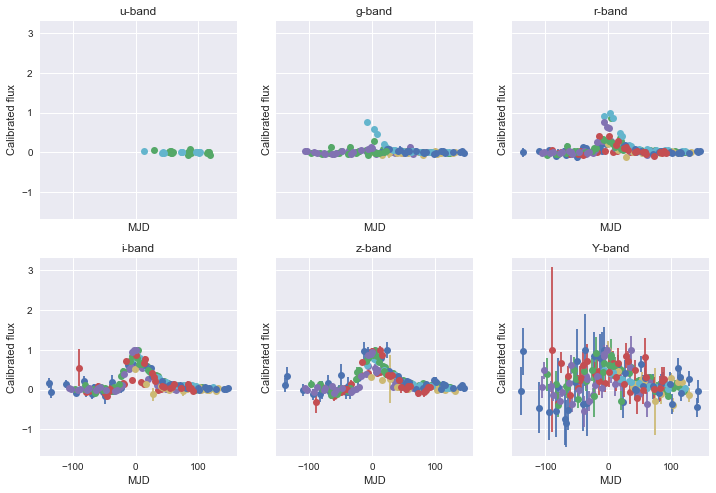

In [22]:
# set the number of light curves to plot
nplots = 10

fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 8))
for i in range(nplots):
    plot_lightcurves(i, X)

If you wish to plot one specific light curve, e.g. again SN 1618,

In [23]:
def plot_lightcurves_id(idx, X):    
    
    flux = []
    for f in LSST_FILTERS:
        if len(X.loc[idx]['fluxcal_' + f]) > 0:
            flux.append(max(X.loc[idx]['fluxcal_' + f]))
            
    fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 8))        
            
    for id_f, f in enumerate(LSST_FILTERS):
        
        
        ax = axes[id_f // 3, id_f % 3]
        ax.errorbar(X.loc[idx]['mjd_%s' % f] - X.loc[idx]['pkmjd'], 
                    X.loc[idx]['fluxcal_%s' % f]/max(flux), 
                    X.loc[idx]['fluxcalerr_%s' % f]/max(flux), 
                    fmt='o')
        ax.set_xlabel('MJD')
        ax.set_ylabel('Calibrated flux')
        ax.set_title('%s-band' % f)

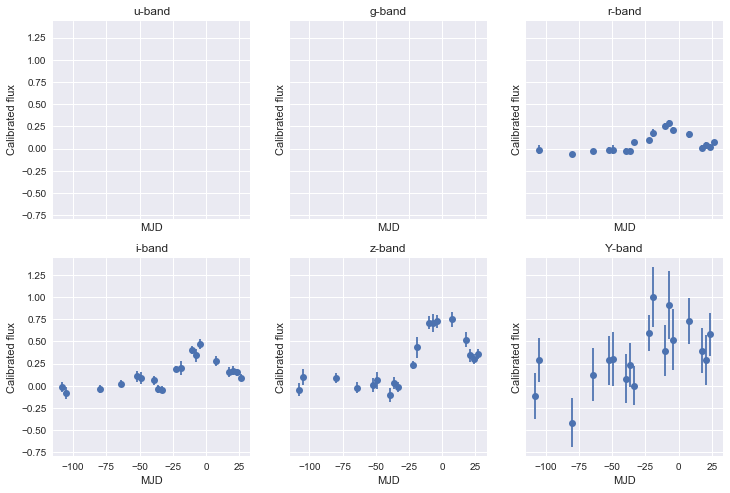

In [24]:
plot_lightcurves_id(1618, X)

## Example of population tests

Bellow are just a few examples I could quickly think of. 
Feel free to add as much as you want

### Flux values

Check the minimum and maximum values for all filters

In [25]:
max_flux = {}
min_flux = {}

# for each filter
for f in LSST_FILTERS:
    max_flux[f] = []
    min_flux[f] = []
    
    # get the flux values
    for indx in range(len(X)):
        if len(X.iloc[indx]['fluxcal_' + f]) > 0:
            max_flux[f].append(max(X.iloc[indx]['fluxcal_' + f]))
            min_flux[f].append(min(X.iloc[indx]['fluxcal_' + f]))                   

After this information is gathered we can check the the distribution of its values

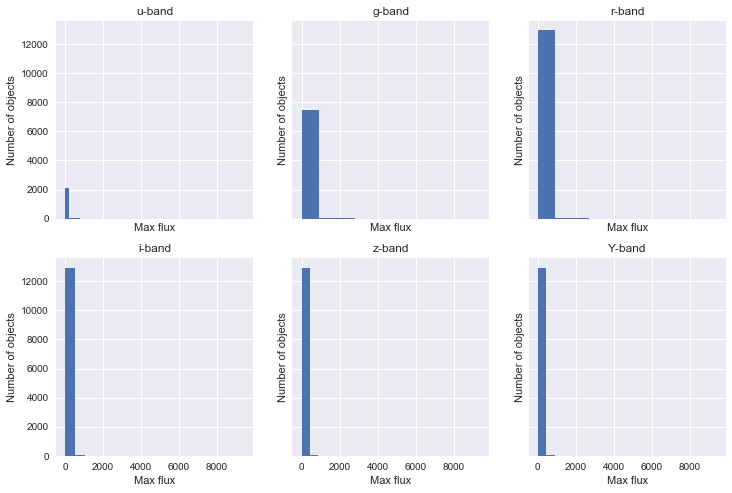

In [26]:
fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 8))     
for id_f, f in enumerate(LSST_FILTERS):        
    ax = axes[id_f // 3, id_f % 3]
    ax.hist(max_flux[f])
    ax.set_xlabel('Max flux')
    ax.set_ylabel('Number of objects')
    ax.set_title('%s-band' % f)

In [28]:
for f in LSST_FILTERS:
    print(min(max_flux[f]), max(max_flux[f]))

-2.15529 1891.65
-0.56409 9410.94
0.662432 8931.69
2.0589 5249.44
2.05842 4218.52
-12.7001 4439.85


Same thing for minimum values

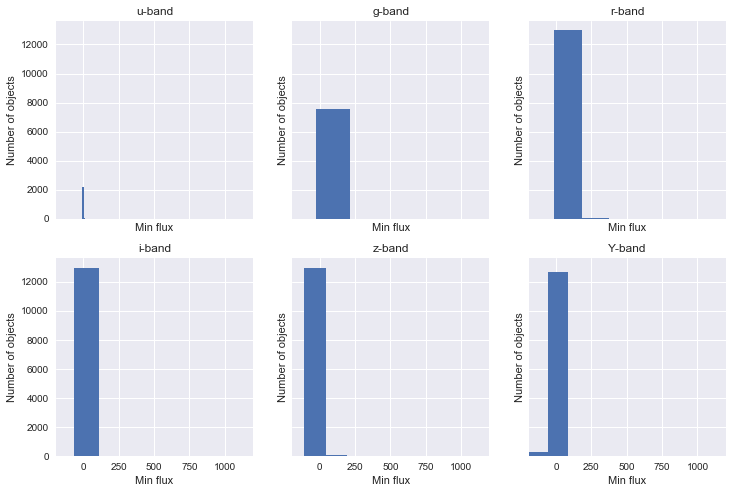

In [29]:
fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 8))     
for id_f, f in enumerate(LSST_FILTERS):        
    ax = axes[id_f // 3, id_f % 3]
    ax.hist(min_flux[f])
    ax.set_xlim(min(min_flux[f]), max(min_flux[f]))
    ax.set_xlabel('Min flux')
    ax.set_ylabel('Number of objects')
    ax.set_title('%s-band' % f)

In [30]:
for f in LSST_FILTERS:
    print(min(min_flux[f]), max(min_flux[f]))

-11.8686 111.364
-24.7223 2368.56
-12.7374 1921.76
-67.6075 1726.41
-108.279 1409.79
-194.264 1199.2


## Compare with ideal simulations

Using the same procedure we used before, generate the pkl files for the ideal simulations

```
>> python serialize_lsst_sn_sims.py ../../data/IDEAL_2018-02-11/IDEAL_MODEL01/ --timed
```

this will generate a `IDEAL_MODEL01_train.pkl` in your local directory.


You can read the data as before:

In [31]:
X1, y1 = read_data('IDEAL_MODEL01_train.pkl')

In [32]:
y1[:10]

""
1
3
6
8
95
103
106
107
149
206


And plot some ID

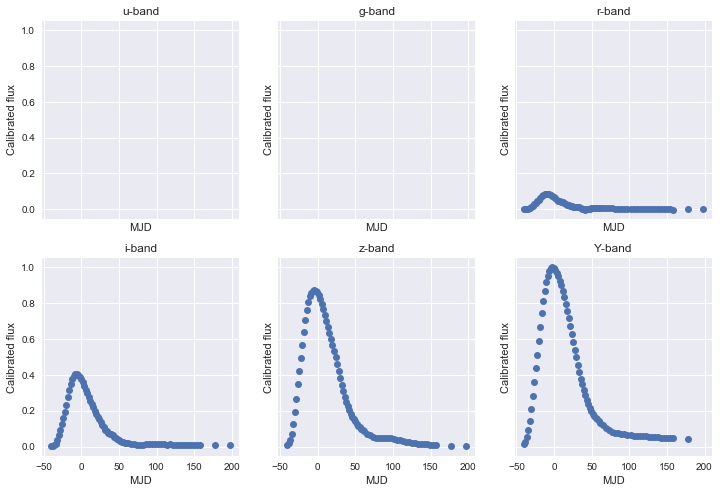

In [33]:
plot_lightcurves_id(1, X1)

Suppose we wish to compare our pet project SN 1618 from the non-ideal simuations. We can check its redshift:

In [34]:
z1618 = X.z[1618]
z1618

1.1337954998016357

now which ideal simulations are close to it in redshift

In [41]:
neighbors = [i for i in range(y1.shape[0]) if abs(X1.z[y1.index[i]] - z1618) <= 0.001] 
neighbors[:10]
X1.z[y1.index[741]]

1.1341478824615479

Plot them all

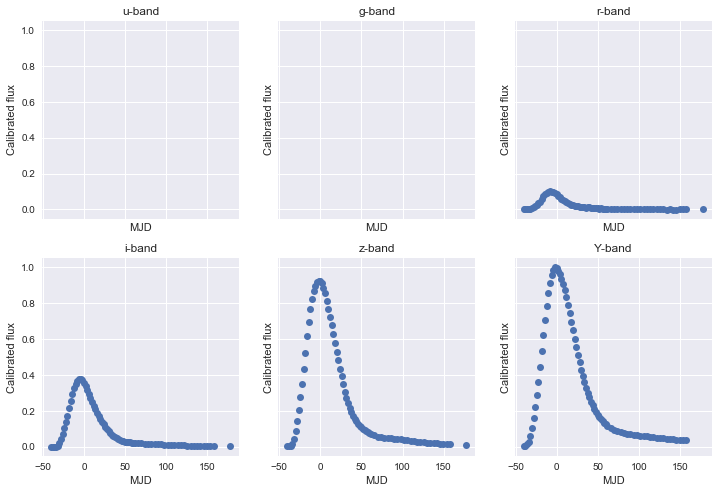

In [37]:
fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 8))
for i in neighbors[:1]:
    plot_lightcurves(i, X1)

Superimpose the non-ideal light curve.

In [38]:
snid = 1618

def plot_lightcurves_ideal_compare(snid, X, neighbors, X1):  
    
    fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 8)) 
    
    for idx in neighbors:
        flux = []
        for f in LSST_FILTERS:
            if len(X1.iloc[idx]['fluxcal_' + f]) > 0:
                flux.append(max(X1.iloc[idx]['fluxcal_' + f]))
   
        for id_f, f in enumerate(LSST_FILTERS):
            ax = axes[id_f // 3, id_f % 3]
            ax.errorbar(X1.iloc[idx]['mjd_%s' % f] - X1.iloc[idx]['pkmjd'], 
                        X1.iloc[idx]['fluxcal_%s' % f]/max(flux), 
                        X1.iloc[idx]['fluxcalerr_%s' % f]/max(flux), 
                        fmt='o')
            ax.set_xlabel('MJD')
            ax.set_ylabel('Calibrated flux')
            ax.set_title('%s-band' % f)
    
    flux2 = []
    for f in LSST_FILTERS:
        if len(X.loc[snid]['fluxcal_' + f]) > 0:
            flux2.append(max(X.loc[snid]['fluxcal_' + f]))
    
    for id_f, f in enumerate(LSST_FILTERS):
        ax = axes[id_f // 3, id_f % 3]
        ax.errorbar(X.loc[snid]['mjd_%s' % f] - X.loc[snid]['pkmjd'], 
                    X.loc[snid]['fluxcal_%s' % f]/max(flux), 
                    X.loc[snid]['fluxcalerr_%s' % f]/max(flux), 
                    fmt='o', color='black')
        ax.set_xlabel('MJD')
        ax.set_ylabel('Calibrated flux')
        ax.set_title('%s-band' % f)

In the plot bellow, the black points corresponto the realistic light curve and the other colors to perfect simulations (high cadence and no noise)

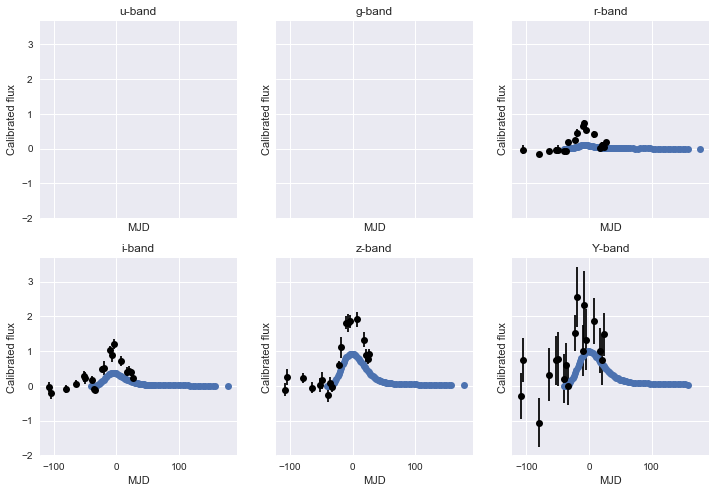

In [39]:
plot_lightcurves_ideal_compare(snid, X, neighbors[:1], X1)

In [47]:
print(X.z[1])
neighbors = [i for i in range(y1.shape[0]) if abs(X1.z[y1.index[i]] - X.z[1]) <= 0.001] 
print(neighbors[:10])
print(X1.z[y1.index[821]])

1.00398945808
[821, 2466, 2748, 3140, 3451, 3506]
1.00434029102


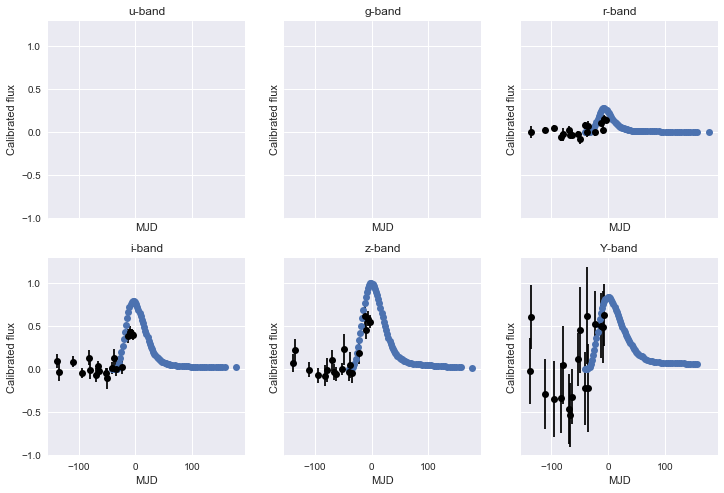

In [49]:
plot_lightcurves_ideal_compare(1, X, [821], X1)

In [57]:
X.z[11]

0.41188079118728638

0.411880791187
[956, 1865, 2849]
0.412543118


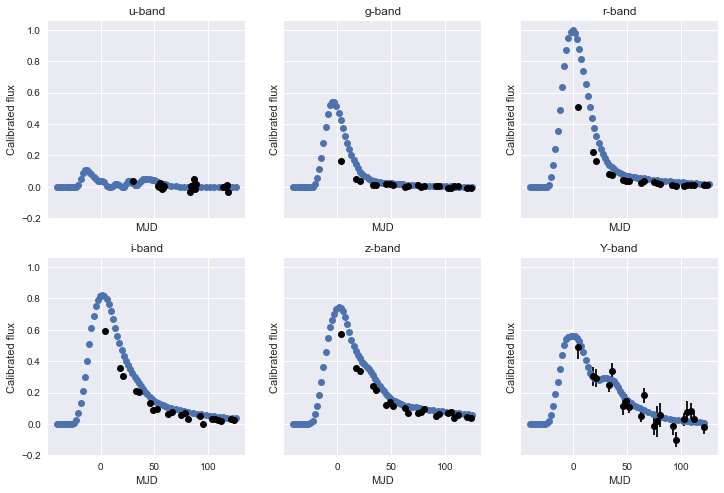

In [59]:
index = 11
print(X.z[index])
neighbors = [i for i in range(y1.shape[0]) if abs(X1.z[y1.index[i]] - X.z[index]) <= 0.001] 
print(neighbors[:10])
print(X1.z[y1.index[neighbors[0]]])
plot_lightcurves_ideal_compare(index, X, neighbors[:1], X1)

In [63]:
y[:10]

""
1
11
37
50
121
133
137
154
156
164


1.28400492668
[134, 693, 992, 1448, 1510, 1824, 3190, 3459, 3643, 3925]
1.28455507755


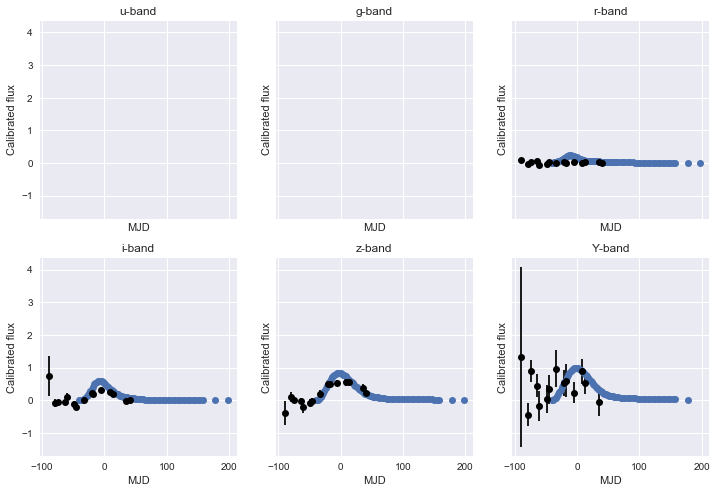

In [64]:
index = 37
print(X.z[index])
neighbors = [i for i in range(y1.shape[0]) if abs(X1.z[y1.index[i]] - X.z[index]) <= 0.001] 
print(neighbors[:10])
print(X1.z[y1.index[neighbors[0]]])
plot_lightcurves_ideal_compare(index, X, neighbors[:1], X1)

0.767486512661
[615, 820, 2813, 2823, 3284]
0.767319500446


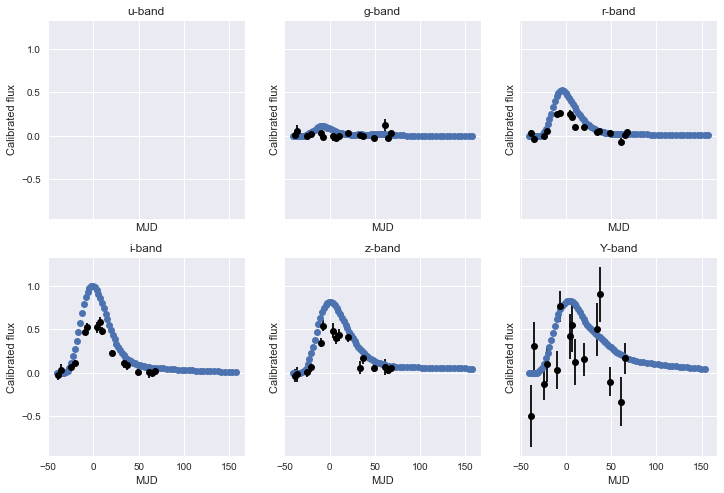

In [65]:
index = 50
print(X.z[index])
neighbors = [i for i in range(y1.shape[0]) if abs(X1.z[y1.index[i]] - X.z[index]) <= 0.001] 
print(neighbors[:10])
print(X1.z[y1.index[neighbors[0]]])
plot_lightcurves_ideal_compare(index, X, neighbors[:1], X1)

0.789673864841
[415, 620, 661, 952, 1433, 3691, 3701, 3946]
0.789819955826


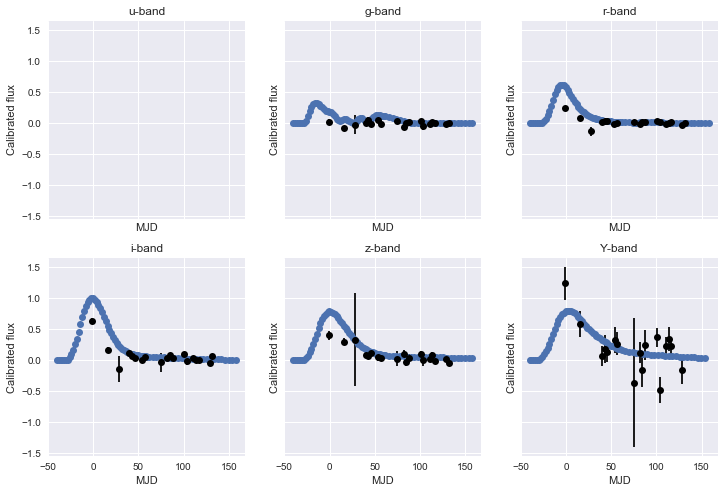

In [66]:
index = 121
print(X.z[index])
neighbors = [i for i in range(y1.shape[0]) if abs(X1.z[y1.index[i]] - X.z[index]) <= 0.001] 
print(neighbors[:10])
print(X1.z[y1.index[neighbors[0]]])
plot_lightcurves_ideal_compare(index, X, neighbors[:1], X1)

0.401544392109
[2999, 3453, 3697]
0.401739537716


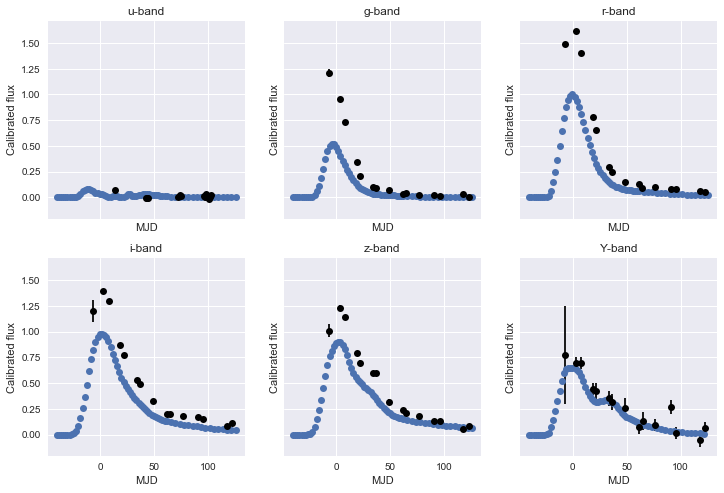

In [67]:
index = 133
print(X.z[index])
neighbors = [i for i in range(y1.shape[0]) if abs(X1.z[y1.index[i]] - X.z[index]) <= 0.001] 
print(neighbors[:10])
print(X1.z[y1.index[neighbors[0]]])
plot_lightcurves_ideal_compare(index, X, neighbors[:1], X1)

0.826786756516
[1422]
0.826013028622


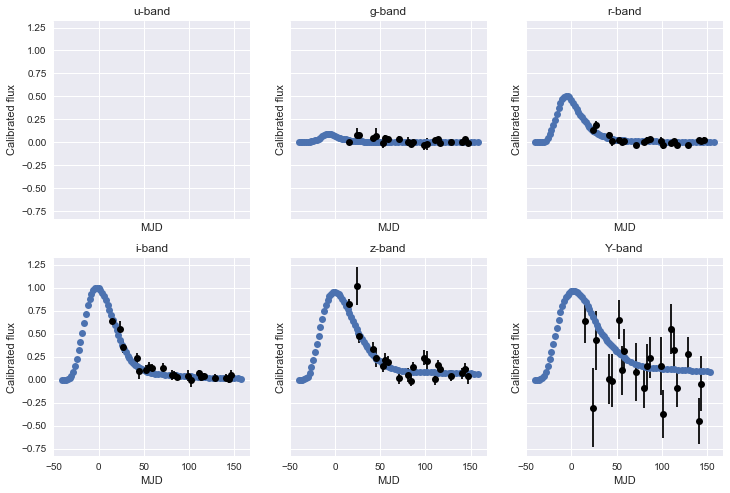

In [68]:
index = 137
print(X.z[index])
neighbors = [i for i in range(y1.shape[0]) if abs(X1.z[y1.index[i]] - X.z[index]) <= 0.001] 
print(neighbors[:10])
print(X1.z[y1.index[neighbors[0]]])
plot_lightcurves_ideal_compare(index, X, neighbors[:1], X1)

In [69]:
y[:10]

""
1
11
37
50
121
133
137
154
156
164


0.905485987663
[438, 1757, 2800, 2896, 3677]
0.905921757221


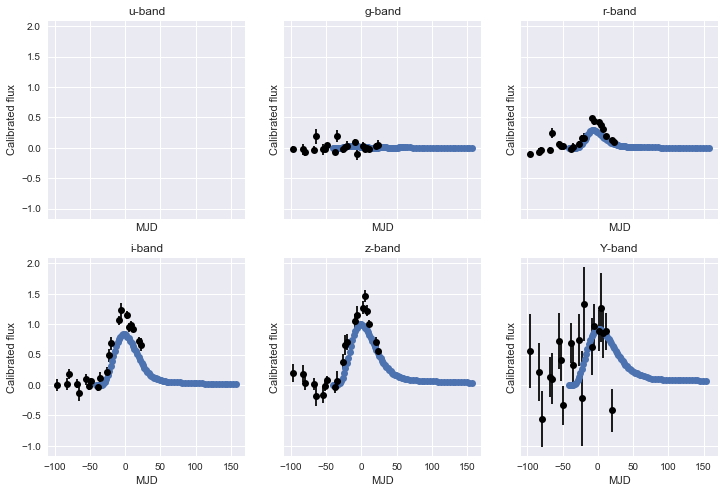

In [70]:
index = 154
print(X.z[index])
neighbors = [i for i in range(y1.shape[0]) if abs(X1.z[y1.index[i]] - X.z[index]) <= 0.001] 
print(neighbors[:10])
print(X1.z[y1.index[neighbors[0]]])
plot_lightcurves_ideal_compare(index, X, neighbors[:1], X1)

1.01606166363
[314, 322, 325, 335, 857, 946, 1147, 2091, 2500, 2718]
1.016289711


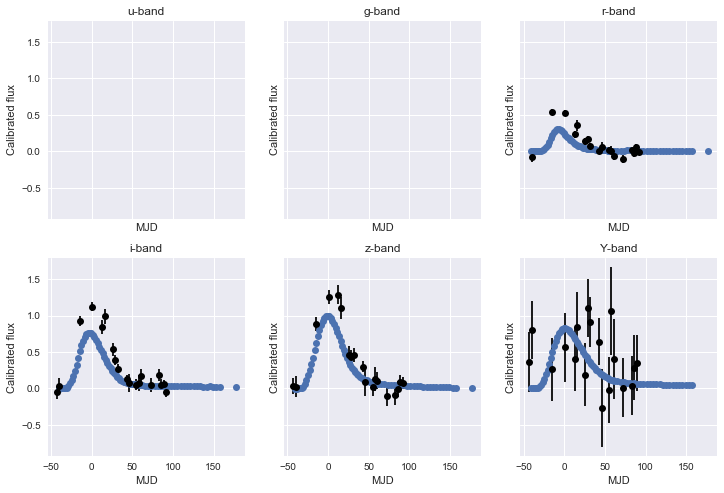

In [71]:
index = 156
print(X.z[index])
neighbors = [i for i in range(y1.shape[0]) if abs(X1.z[y1.index[i]] - X.z[index]) <= 0.001] 
print(neighbors[:10])
print(X1.z[y1.index[neighbors[0]]])
plot_lightcurves_ideal_compare(index, X, neighbors[:1], X1)

0.690309166908
[574, 2260, 2287, 2625, 3346]
0.690612912178


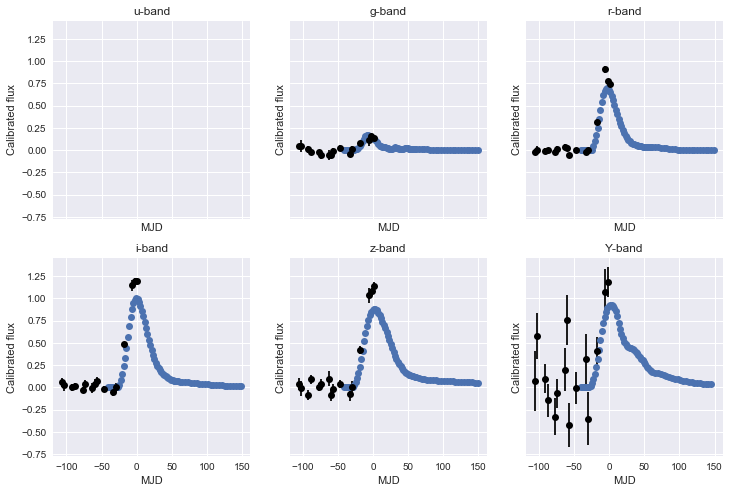

In [72]:
index = 164
print(X.z[index])
neighbors = [i for i in range(y1.shape[0]) if abs(X1.z[y1.index[i]] - X.z[index]) <= 0.001] 
print(neighbors[:10])
print(X1.z[y1.index[neighbors[0]]])
plot_lightcurves_ideal_compare(index, X, neighbors[:1], X1)

In [73]:
y[8:18]

""
156
164
186
187
204
280
345
349
352
360


0.61435431242
[902, 1035, 1148, 1659, 2686, 3394, 3460]
0.614376485348


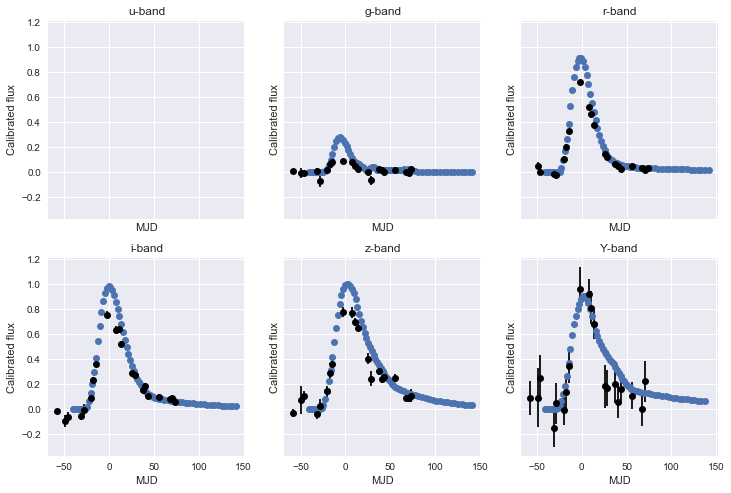

In [74]:
index = 186
print(X.z[index])
neighbors = [i for i in range(y1.shape[0]) if abs(X1.z[y1.index[i]] - X.z[index]) <= 0.001] 
print(neighbors[:10])
print(X1.z[y1.index[neighbors[0]]])
plot_lightcurves_ideal_compare(index, X, neighbors[:1], X1)

0.851076245308
[264, 279, 423, 1774, 2023, 2773, 3863]
0.850540280342


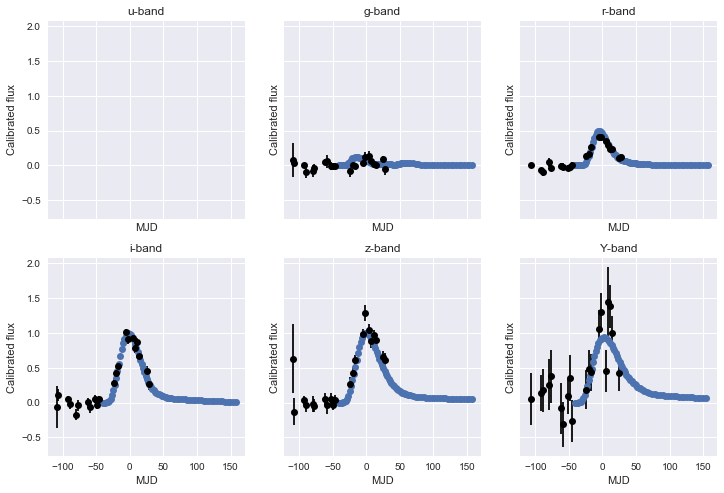

In [75]:
index = 187
print(X.z[index])
neighbors = [i for i in range(y1.shape[0]) if abs(X1.z[y1.index[i]] - X.z[index]) <= 0.001] 
print(neighbors[:10])
print(X1.z[y1.index[neighbors[0]]])
plot_lightcurves_ideal_compare(index, X, neighbors[:1], X1)

0.573836147785
[930, 1145, 2019, 2207, 2617, 2640, 2935, 3930, 3935]
0.573650538921


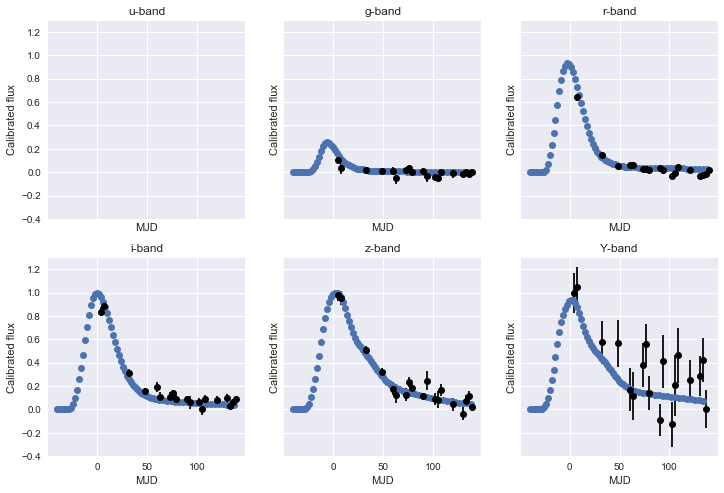

In [76]:
index = 204
print(X.z[index])
neighbors = [i for i in range(y1.shape[0]) if abs(X1.z[y1.index[i]] - X.z[index]) <= 0.001] 
print(neighbors[:10])
print(X1.z[y1.index[neighbors[0]]])
plot_lightcurves_ideal_compare(index, X, neighbors[:1], X1)

1.27479016781
[181, 1245, 1495, 1649, 2178, 2792, 3026, 3060, 3322, 3936]
1.27553594112


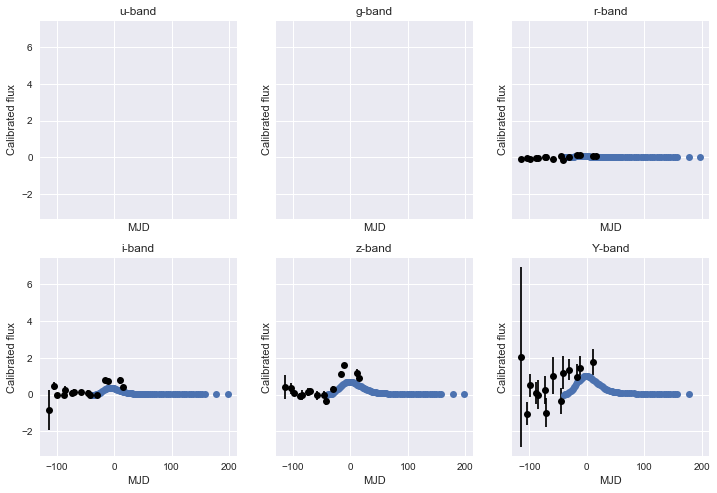

In [77]:
index = 280
print(X.z[index])
neighbors = [i for i in range(y1.shape[0]) if abs(X1.z[y1.index[i]] - X.z[index]) <= 0.001] 
print(neighbors[:10])
print(X1.z[y1.index[neighbors[0]]])
plot_lightcurves_ideal_compare(index, X, neighbors[:1], X1)

1.29601585865
[3, 108, 740, 1410, 2459, 3646]
1.29512155056


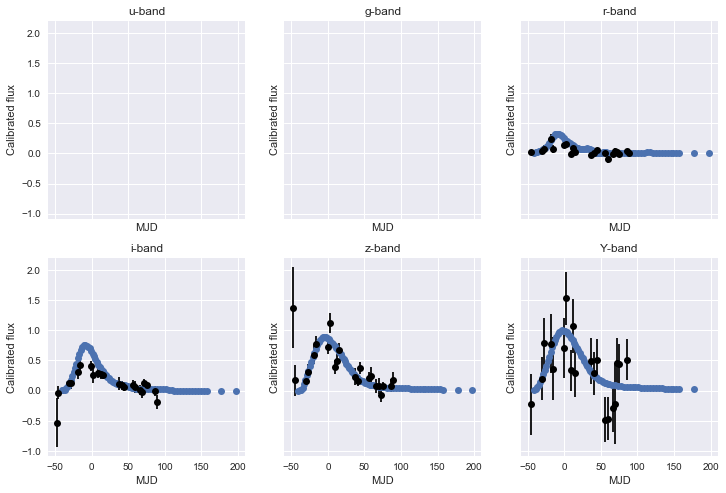

In [78]:
index = 345
print(X.z[index])
neighbors = [i for i in range(y1.shape[0]) if abs(X1.z[y1.index[i]] - X.z[index]) <= 0.001] 
print(neighbors[:10])
print(X1.z[y1.index[neighbors[0]]])
plot_lightcurves_ideal_compare(index, X, neighbors[:1], X1)

0.877175807953
[155, 1093, 1437, 2586, 3656, 3678]
0.876887798309


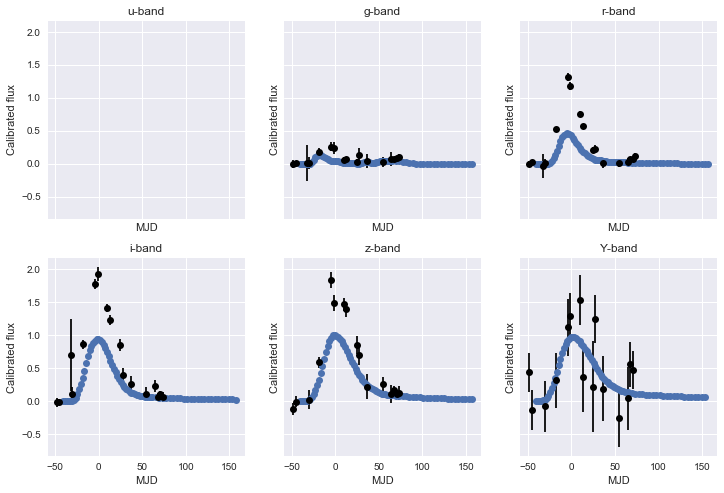

In [79]:
index = 349
print(X.z[index])
neighbors = [i for i in range(y1.shape[0]) if abs(X1.z[y1.index[i]] - X.z[index]) <= 0.001] 
print(neighbors[:10])
print(X1.z[y1.index[neighbors[0]]])
plot_lightcurves_ideal_compare(index, X, neighbors[:1], X1)

0.491233497858
[2192, 2274, 3420, 3722]
0.491686344147


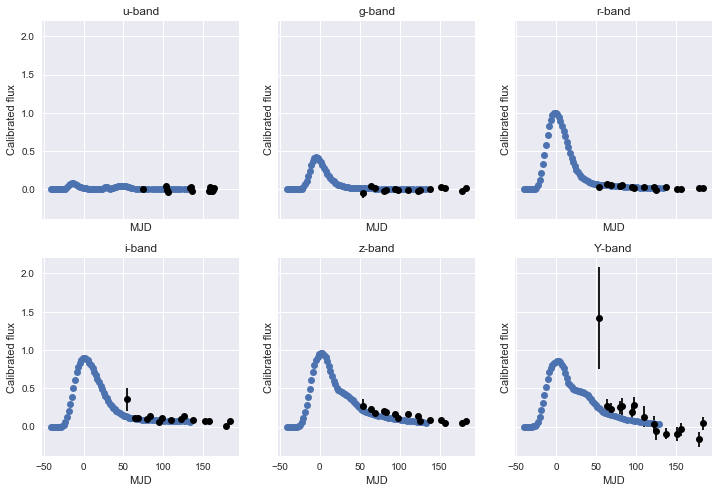

In [80]:
index = 352
print(X.z[index])
neighbors = [i for i in range(y1.shape[0]) if abs(X1.z[y1.index[i]] - X.z[index]) <= 0.001] 
print(neighbors[:10])
print(X1.z[y1.index[neighbors[0]]])
plot_lightcurves_ideal_compare(index, X, neighbors[:1], X1)

1.13736903667
[263, 699, 1614, 1930, 2065, 2453, 3043, 3933]
1.13670551777


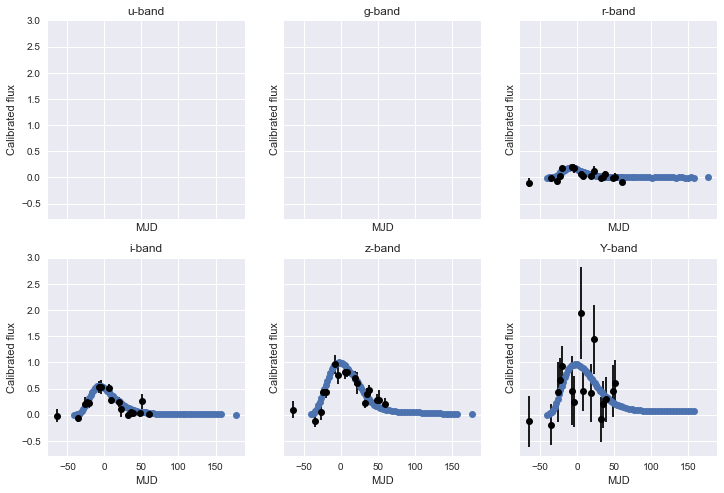

In [81]:
index = 360
print(X.z[index])
neighbors = [i for i in range(y1.shape[0]) if abs(X1.z[y1.index[i]] - X.z[index]) <= 0.001] 
print(neighbors[:10])
print(X1.z[y1.index[neighbors[0]]])
plot_lightcurves_ideal_compare(index, X, neighbors[:1], X1)